The goal of this notebook is to generate data for our experiments.

The generated data will have:
* correlated and uncorrelated normally distributed variables
* ordinal variables
* categorical variables
* different scales
* skewed variables

With this data, we will create specific target variables, obtained both by linear and non-linear relationships by using
* All the variables
* Only half of the variables
* Only 10 variables
* Only 3 variables

Moreover, we will also make these data dirtier (after creating the target variables) by
* adding random noise
* removing random entries (or random entries based on categories)
* adding outliers

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import string
import random
import pickle

import source.explore as exp

from sklearn.datasets import make_regression

%matplotlib inline
pd.set_option('max_columns', 500)
np.random.seed(23)
random.seed(23)

# Data generation

In [2]:
def make_uncorrelated(data, n_entries):
    df = data.copy()
    np.random.seed(23)
    random.seed(23)
    # normal distributions
    ran_loc = np.random.normal(loc=1, scale=0.8, size=20)
    ran_scl = np.random.uniform(low=0.01, high=3, size=20)
    for i in range(1,21):
        df[f'unc_normal_{i}'] = np.random.normal(loc=ran_loc[i-1], scale=ran_scl[i-1], size=n_entries)
        
    # Skewed distribution
    df['unc_skewed_pos'] = np.expm1(np.random.normal(loc=1.3, scale=0.5, size=n_entries))
    df['unc_skewed_neg'] = 40 - np.expm1(np.random.normal(loc=2.3, scale=0.3, size=n_entries))
    
    # categorical variables
    df['unc_binary_1'] = np.random.choice([0, 1], size=(n_entries,), p=[1/3, 2/3])
    df['unc_binary_2'] = np.random.choice([0, 1], size=(n_entries,), p=[1/2, 1/2])
    df['unc_binary_3'] = np.random.choice([0, 1], size=(n_entries,), p=[1/5, 4/5])
    df['unc_binary_4'] = np.random.choice([0, 1], size=(n_entries,), p=[1/4, 3/4])
    df['unc_binary_5'] = np.random.choice([0, 1], size=(n_entries,), p=[1/10, 9/10])
    
    df['unc_categories_5'] = np.random.choice(['a', 'b', 'c', 'd', 'e'], size=(n_entries,), p=[2/5, 1/5, 1/10, 3/15, 1/10])
    df['unc_categories_3'] = np.random.choice(['a', 'b', 'c'], size=(n_entries,))
    
    for i in range(1,12):
        df[f'unc_ordinal_{i}'] = np.random.choice(np.arange(1,i*10), size=(n_entries,))
    
    return df


def make_correlated(data, n_entries):
    df = data.copy()
    np.random.seed(23)
    random.seed(23)
    # correlation with 1 category
    df['corr_cat_1'] = np.random.choice([0, 1], size=(n_entries,), p=[1/3, 2/3])
    df['corr_cat_2'] = np.random.choice([0, 1], size=(n_entries,))
    df.loc[df.corr_cat_1 == 0, 'corr_normal_by_cat'] = np.random.normal(loc=-0.5, scale=0.4, size=n_entries - df.corr_cat_1.sum())
    df.loc[df.corr_cat_1 == 1, 'corr_normal_by_cat'] = np.random.normal(loc=1, scale=0.2, size=df.corr_cat_1.sum())
    
    # correlation with 2 categories
    tmp = df.groupby(['corr_cat_1', 'corr_cat_2']).size()
    df.loc[(df.corr_cat_1 == 0) & (df.corr_cat_2 == 0) , 'corr_normal_by_2cats'] = np.random.normal(loc=2, scale=0.4, size=tmp[0][0])
    df.loc[(df.corr_cat_1 == 0) & (df.corr_cat_2 == 1) , 'corr_normal_by_2cats'] = np.random.normal(loc=4, scale=0.65, size=tmp[0][1])
    df.loc[(df.corr_cat_1 == 1) & (df.corr_cat_2 == 0) , 'corr_normal_by_2cats'] = np.random.normal(loc=1, scale=1, size=tmp[1][0])
    df.loc[(df.corr_cat_1 == 1) & (df.corr_cat_2 == 1) , 'corr_normal_by_2cats'] = np.random.normal(loc=-1, scale=0.5, size=tmp[1][1])
    
    # multinormals with different correlations
    df['corr_multinormal_high_a'] = 0
    df['corr_multinormal_high_b'] = 0
    df[['corr_multinormal_high_a', 'corr_multinormal_high_b']] = np.random.multivariate_normal(mean=[6, -2], cov=[[2, -0.8], [-0.8, 0.5]], size=n_entries)
    
    df['corr_multinormal_mid_a'] = 0
    df['corr_multinormal_mid_b'] = 0
    df[['corr_multinormal_mid_a', 'corr_multinormal_mid_b']] = np.random.multivariate_normal(mean=[20, 11], cov=[[7, 2.9], [2.9, 5]], size=n_entries)
    
    df['corr_multinormal_low_a'] = 0
    df['corr_multinormal_low_b'] = 0
    df[['corr_multinormal_low_a', 'corr_multinormal_low_b']] = np.random.multivariate_normal(mean=[-6, 4], cov=[[1, 0.3], [0.3, 2]], size=n_entries)
    
    df[['corr_multinormal_mid_a', 'corr_multinormal_mid_b', 
        'corr_multinormal_low_a', 'corr_multinormal_low_b']] += np.random.multivariate_normal(mean=[0, 0, 0, 0], 
                                                                                              cov=[[2, -0.8, -1.2, 0.02], 
                                                                                                   [-0.8, 0.5, 0, 0], 
                                                                                                   [-1.2, 0, 7, 0.9], 
                                                                                                   [0.02, 0, 0.9, 5]], size=n_entries)
    
    return df


def make_confounding(data):
    df = data.copy()
    np.random.seed(23)
    random.seed(23)
    n_entries = data.shape[0]
    
    # normal distributions uncorrelated from the rest
    ran_loc = np.random.normal(loc=0, scale=1, size=40)
    ran_scl = np.random.uniform(low=0.01, high=5, size=40)
    for i in range(1,41):
        df[f'conf_normal_{i}'] = np.random.normal(loc=ran_loc[i-1], scale=ran_scl[i-1], size=n_entries)
        
    # interactions of other variables with small noise
    for i in range(1,6):
        df[f'conf_inter_{i}'] = df[f'unc_normal_{i}'] * df[f'unc_normal_{i+10}'] + np.random.normal(loc=0, scale=0.2, size=n_entries)
        
    df['conf_inter_6'] = df['unc_skewed_pos'] * df['corr_multinormal_high_a'] + np.random.normal(loc=0, scale=0.1, size=n_entries)
    df['conf_inter_7'] = df['unc_binary_4'] * df['unc_binary_2'] + np.random.normal(loc=1, scale=0.1, size=n_entries)
    df['conf_inter_8'] = df['unc_binary_1'] * df['unc_binary_2'] + np.random.normal(loc=0.1, scale=0.2, size=n_entries)
    df['conf_inter_9'] = df['corr_multinormal_mid_b'] * df['corr_multinormal_low_b'] + np.random.normal(loc=-0.1, scale=0.1, size=n_entries)
    df['conf_inter_10'] = df['corr_multinormal_low_a'] * df['unc_normal_19'] + np.random.normal(loc=-1, scale=0.2, size=n_entries)
    
    return df

In [3]:
data = pd.DataFrame()

data = make_uncorrelated(data, 100000)
data = make_correlated(data, 100000)
data = make_confounding(data)

data.head()

,unc_normal_1,unc_normal_2,unc_normal_3,unc_normal_4,unc_normal_5,unc_normal_6,unc_normal_7,unc_normal_8,unc_normal_9,unc_normal_10,unc_normal_11,unc_normal_12,unc_normal_13,unc_normal_14,unc_normal_15,unc_normal_16,unc_normal_17,unc_normal_18,unc_normal_19,unc_normal_20,unc_skewed_pos,unc_skewed_neg,unc_binary_1,unc_binary_2,unc_binary_3,unc_binary_4,unc_binary_5,unc_categories_5,unc_categories_3,unc_ordinal_1,unc_ordinal_2,unc_ordinal_3,unc_ordinal_4,unc_ordinal_5,unc_ordinal_6,unc_ordinal_7,unc_ordinal_8,unc_ordinal_9,unc_ordinal_10,unc_ordinal_11,corr_cat_1,corr_cat_2,corr_normal_by_cat,corr_normal_by_2cats,corr_multinormal_high_a,corr_multinormal_high_b,corr_multinormal_mid_a,corr_multinormal_mid_b,corr_multinormal_low_a,corr_multinormal_low_b,conf_normal_1,conf_normal_2,conf_normal_3,conf_normal_4,conf_normal_5,conf_normal_6,conf_normal_7,conf_normal_8,conf_normal_9,conf_normal_10,conf_normal_11,conf_normal_12,conf_normal_13,conf_normal_14,conf_normal_15,conf_normal_16,conf_normal_17,conf_normal_18,conf_normal_19,conf_normal_20,conf_normal_21,conf_normal_22,conf_normal_23,conf_normal_24,conf_normal_25,conf_normal_26,conf_normal_27,conf_normal_28,conf_normal_29,conf_normal_30,conf_normal_31,conf_normal_32,conf_normal_33,conf_normal_34,conf_normal_35,conf_normal_36,conf_normal_37,conf_normal_38,conf_normal_39,conf_normal_40,conf_inter_1,conf_inter_2,conf_inter_3,conf_inter_4,conf_inter_5,conf_inter_6,conf_inter_7,conf_inter_8,conf_inter_9,conf_inter_10
0,3.116159,1.721656,3.960629,-2.434819,1.571768,-0.463757,0.471428,0.053728,-0.068983,3.661687,0.711273,-0.140425,1.906761,1.173943,0.346412,-0.697281,1.597933,1.656605,-0.653604,-0.055235,4.012600,34.796725,1,0,1,1,1,a,c,9,8,10,27,16,2,22,32,64,99,91,1,0,0.541971,0.351782,8.430675,-3.355695,27.159674,10.704274,-5.322705,7.330677,-0.465424,0.428379,-8.305065,5.433540,0.641474,-0.744669,0.193713,-10.796703,-1.740955,2.789925,4.793788,0.314059,8.809190,-1.724027,-4.859676,-6.392787,0.333997,1.478847,-8.566738,-1.559217,-1.516266,3.860680,2.366172,-2.586560,0.054521,-0.277927,-0.564051,1.594984,-3.057506,2.359598,-3.066961,-2.031134,1.090621,2.271005,-1.542664,0.977127,-1.722407,-0.183448,4.172730,0.060391,2.438407,-0.513521,7.685403,-2.747760,0.665247,33.859922,0.814738,0.118919,78.506972,2.721404
1,1.474749,2.279144,1.363985,0.924290,0.785104,0.950153,0.751243,-0.286628,2.601363,-0.511723,0.649503,-3.462760,1.950268,0.345893,0.373006,-0.398640,1.412010,2.145148,-1.561932,-1.695599,4.173161,32.094422,1,0,1,1,1,a,a,6,7,8,24,21,19,22,64,12,61,70,1,1,0.857349,-0.629935,3.334968,-0.792505,21.696217,11.128385,-6.570617,2.406493,7.850316,5.888023,1.994081,2.331105,0.695217,-1.471434,-4.009850,-8.008990,-1.708479,2.588924,-2.228353,-0.639126,6.769919,-1.032789,2.209520,5.093657,2.435870,-1.191747,3.121220,-1.031572,-0.675103,3.210031,-4.901169,-5.315658,0.715473,-0.098325,-0.353838,1.130485,-0.718112,6.030474,8.606190,-0.125231,1.515643,1.940682,-5.148735,-1.487067,-4.402883,-0.125751,-0.546949,-1.680762,1.450886,-7.877238,2.677800,0.098183,0.530051,13.925376,0.925748,0.230320,26.636887,9.280622
2,1.568631,1.358034,-3.530865,3.196470,1.129391,-1.949721,0.858699,0.083105,0.629930,-0.547036,1.302333,3.936047,-1.068482,5.503111,1.889195,0.764182,1.536993,2.127062,1.393332,0.490684,5.272406,30.858836,1,1,1,1,1,a,c,3,2,12,34,20,46,47,50,57,23,88,1,0,1.244200,2.232988,3.895617,-1.586941,22.708020,10.537641,-4.403688,5.108706,1.437204,-1.072698,1.242264,1.820332,-1.615139,-1.493837,1.253864,-2.667333,-0.460375,3.135342,-4.086399,0.473480,-0.950727,1.942101,0.252077,-0.421147,1.477374,0.137126,-7.004676,0.047859,-2.404984,-1.760097,-5.281338,3.673253,0.158068,-3.225765,0.026224,1.305401,-0.111996,-1.489480,-4.099650,3.310754,0.779214,2.491095,-1.099701,-3.111302,-0.772790,0.088491,3.639642,0.805508,1.749581,5.191982,3.938938,17.852357,2.372882,20.491816,2.294855,0.917542,53.803633,-7.159646
3,3.977022,1.859427,1.041246,1.761997,1.317944,3.559572,0.238095,0.023744,-0.816982,1.711412,0.642428,

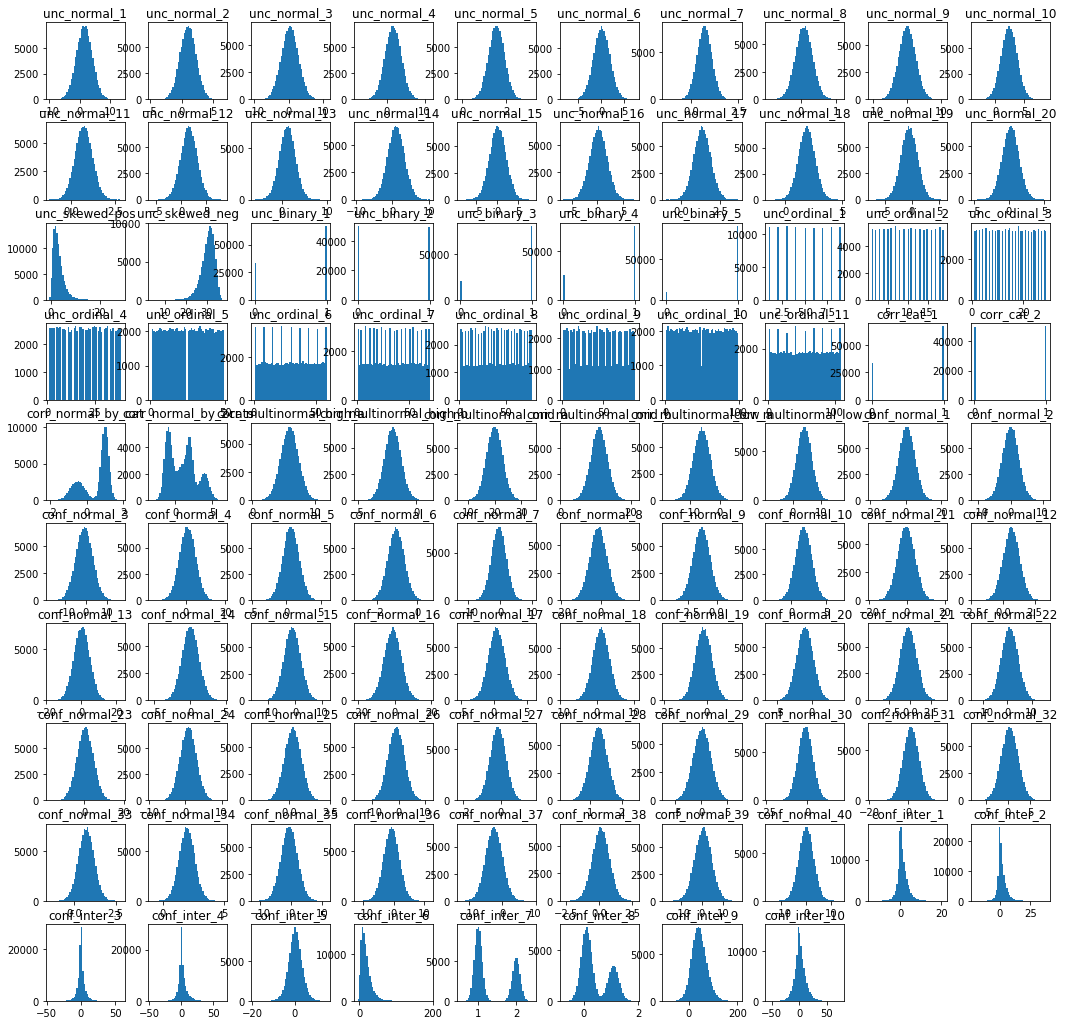

In [4]:
data.hist(bins=50, figsize=(18,18), grid=False)
plt.show()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   unc_normal_1             100000 non-null  float64
 1   unc_normal_2             100000 non-null  float64
 2   unc_normal_3             100000 non-null  float64
 3   unc_normal_4             100000 non-null  float64
 4   unc_normal_5             100000 non-null  float64
 5   unc_normal_6             100000 non-null  float64
 6   unc_normal_7             100000 non-null  float64
 7   unc_normal_8             100000 non-null  float64
 8   unc_normal_9             100000 non-null  float64
 9   unc_normal_10            100000 non-null  float64
 10  unc_normal_11            100000 non-null  float64
 11  unc_normal_12            100000 non-null  float64
 12  unc_normal_13            100000 non-null  float64
 13  unc_normal_14            100000 non-null  float64
 14  unc_

In [6]:
data.describe(include='all').fillna('-')

,unc_normal_1,unc_normal_2,unc_normal_3,unc_normal_4,unc_normal_5,unc_normal_6,unc_normal_7,unc_normal_8,unc_normal_9,unc_normal_10,unc_normal_11,unc_normal_12,unc_normal_13,unc_normal_14,unc_normal_15,unc_normal_16,unc_normal_17,unc_normal_18,unc_normal_19,unc_normal_20,unc_skewed_pos,unc_skewed_neg,unc_binary_1,unc_binary_2,unc_binary_3,unc_binary_4,unc_binary_5,unc_categories_5,unc_categories_3,unc_ordinal_1,unc_ordinal_2,unc_ordinal_3,unc_ordinal_4,unc_ordinal_5,unc_ordinal_6,unc_ordinal_7,unc_ordinal_8,unc_ordinal_9,unc_ordinal_10,unc_ordinal_11,corr_cat_1,corr_cat_2,corr_normal_by_cat,corr_normal_by_2cats,corr_multinormal_high_a,corr_multinormal_high_b,corr_multinormal_mid_a,corr_multinormal_mid_b,corr_multinormal_low_a,corr_multinormal_low_b,conf_normal_1,conf_normal_2,conf_normal_3,conf_normal_4,conf_normal_5,conf_normal_6,conf_normal_7,conf_normal_8,conf_normal_9,conf_normal_10,conf_normal_11,conf_normal_12,conf_normal_13,conf_normal_14,conf_normal_15,conf_normal_16,conf_normal_17,conf_normal_18,conf_normal_19,conf_normal_20,conf_normal_21,conf_normal_22,conf_normal_23,conf_normal_24,conf_normal_25,conf_normal_26,conf_normal_27,conf_normal_28,conf_normal_29,conf_normal_30,conf_normal_31,conf_normal_32,conf_normal_33,conf_normal_34,conf_normal_35,conf_normal_36,conf_normal_37,conf_normal_38,conf_normal_39,conf_normal_40,conf_inter_1,conf_inter_2,conf_inter_3,conf_inter_4,conf_inter_5,conf_inter_6,conf_inter_7,conf_inter_8,conf_inter_9,conf_inter_10
count,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
unique,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,5,3,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
top,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,a,a,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
freq,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,40405,33506,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
mean,1.51524,1.01811,0.370712,1.7672,1.56227,0.164335,0.706288,0.0901219,-0.0344197,2.42499,0.723892,1.53793,1.25583,1.04541,0.156572,0.197313,1.35266,1.90519,-0.47011,0.251205,3.15459,30.5642,0.66521,0.49762,0.79978,0.74915,0.90059,-,-,4.99477,9.99112,14.9833,19.937,24.9797,29.9819,34.953,40.0705,44.8826,49.9093,55.1275,0.66588,0.50123,0.498332,1.00963,6.00213,-1.99846,19.9884,11.0067,-5.99253,4.01254,0.635088,0.0206701,-0.789371,0.964345,0.704686,-1.04994,-0.365249,-1.13611,-1.31528,1.77842,-0.330634,0.670934,0.316862,0.0589262,-1.05684,-0.995565,0.440079,1.13514,-1.83647,-0.93653,-0.204498,1.04601,0.532594,0.798371,0.243328,-0.945555,-0.136502,1.26632,0.172533,-1.21396,1.42116,0.454765,0.725801,1.96826,-0.55762,-0.674361,-2.50659,0.148769,0.612411,-0.0262659,1.09415,1.56445,0.463553,1.83901,0.244976,18.9376,1.3721,0.429698,44.0311,1.81462
std,2.61403,1.28998,2.48397,2.14697,0.366193,1.79286,0.397441,0.242235,2.48868,1.39839,0.493259,1.64399,1.76394,2.32533,1.97145,1.67914,0.544676,0.729417,1.52117,1.19095,2.21874,3.21079,0.471919,0.499997,0.400167,0.433505,0.299213,-,-,2.58584,5.47158,8.35923,11.253,14.1135,17.0337,19.909,22.7371,25.6783,28.5975,31.4717,0.471684,0.500

In [7]:
data[[col for col in data.columns if 'corr_' in col]].corr()

,corr_cat_1,corr_cat_2,corr_normal_by_cat,corr_normal_by_2cats,corr_multinormal_high_a,corr_multinormal_high_b,corr_multinormal_mid_a,corr_multinormal_mid_b,corr_multinormal_low_a,corr_multinormal_low_b
corr_cat_1,1.000000,-0.008561,0.928559,-0.756343,0.002882,-0.005980,0.006337,0.005027,-0.002432,-0.002955
corr_cat_2,-0.008561,1.000000,-0.010041,-0.170186,0.000450,-0.001931,-0.001328,-0.000012,-0.001014,0.002072
corr_normal_by_cat,0.928559,-0.010041,1.000000,-0.701950,0.002613,-0.004975,0.006279,0.004743,-0.002571,-0.004781
corr_normal_by_2cats,-0.756343,-0.170186,-0.701950,1.000000,-0.001224,0.004205,0.000528,-0.002070,-0.000028,0.000977
corr_multinormal_high_a,0.002882,0.000450,0.002613,-0.001224,1.000000,-0.800776,0.001870,0.003020,-0.004733,0.001591
corr_multinormal_high_b,-0.005980,-0.001931,-0.004975,0.004205,-0.800776,1.000000,-0.001532,-0.006589,0.003324,-0.000115
corr_multinormal_mid_a,0.006337,-0.001328,0.006279,0.000528,0.001870,-0.001532,1.000000,0.303468,-0.142300,0.003123
corr_multinormal_mid_b,0.005027,-0.000012,0.004743,-0.002070,0.003020,-0.006589,0.303468,1.000000,-0.001540,-0.005495
corr_multinormal_low_a,-0.002432,-0.001014,-0.002571,-0.000028,-0.004733,0.003324,-0.142300,-0.001540,1.000000,0.159693
corr_multinormal_low_b,-0.002955,0.002072,-0.004781,0.000977,0.001591,-0.000115,0.003123,-0.005495,0.159693,1.000000


# Target variables creation

In [8]:
def linear_targets(data, tmp):
    df = data.copy()
    np.random.seed(2332)
    random.seed(234)
    entries = df.shape[0]
    
    coef_dict = {}
    
    # all
    coefs = np.random.normal(loc=0, scale=0.5, size=tmp.shape[1])
    df['tar_lin_full'] = tmp.multiply(coefs, axis=1).sum(axis=1) + np.random.normal(20, 10, size=entries)
    coef_dict['tar_lin_full'] = pd.DataFrame({'feat': tmp.columns, 'coef': coefs})
    
    # with half of them
    to_use = random.sample([col for col in tmp.columns if 'conf_' not in col], 50)
    coefs = np.random.normal(loc=0, scale=2, size=len(to_use))
    df['tar_lin_half'] = tmp[to_use].multiply(coefs, axis=1).sum(axis=1) + np.random.normal(-20, 10, size=entries)
    coef_dict['tar_lin_half'] = pd.DataFrame({'feat': to_use, 'coef': coefs})
    
    # with 10 of them
    to_use = random.sample([col for col in tmp.columns if 'conf_' not in col and 'categories' not in col], 10)
    coefs = np.random.normal(loc=0, scale=0.5, size=len(to_use))
    df['tar_lin_10'] = tmp[to_use].multiply(coefs, axis=1).sum(axis=1) + np.random.normal(0, 1, size=entries)
    coef_dict['tar_lin_10'] = pd.DataFrame({'feat': to_use, 'coef': coefs})
    
    return df, coef_dict


def nonlinear_targets(data, tmp):
    df = data.copy()
    np.random.seed(23)
    entries = df.shape[0]
    
    coef_dict = {}
    
    df['tar_nonlin_10'] = -200 + (0.3 * df['unc_normal_1']**2 
                           -0.7 * df['unc_normal_7']**2 
                           -1 * df['unc_skewed_pos'] * df['unc_skewed_neg'] 
                           +0.8 * df['corr_multinormal_mid_a']**2 
                           +0.5 * df['unc_ordinal_5'] * df['unc_normal_12'] 
                           -0.4 * df['unc_normal_14'] * df['corr_normal_by_cat'] 
                           + df['unc_normal_1'] * df['unc_normal_7']
                          )
    coef_dict['tar_nonlin_10'] = pd.DataFrame({'feat': ['unc_normal_1_sq', 
                                                        'unc_normal_7_sq', 
                                                        'unc_skewed_int', 
                                                        'corr_multinormal_mid_a_sq', 
                                                        'unc_ordinal_5_12', 
                                                        'unc_normal_14_by_cat', 
                                                        'unc_normal_1_7'],
                                               'coef': [0.3, -0.7, -1, 0.8, 0.5, -0.4, 1]})
    
    return df, coef_dict


def make_targets(data):
    tmp = data.copy()
    tmp = pd.get_dummies(tmp, drop_first=True)
    
    df, coef_lin = linear_targets(data, tmp)
    df, coef_nonlin = nonlinear_targets(df, tmp)

    return df, coef_lin, coef_nonlin

In [9]:
data, coefs_linear, coefs_nonlinear = make_targets(data) 

data.head()

,unc_normal_1,unc_normal_2,unc_normal_3,unc_normal_4,unc_normal_5,unc_normal_6,unc_normal_7,unc_normal_8,unc_normal_9,unc_normal_10,unc_normal_11,unc_normal_12,unc_normal_13,unc_normal_14,unc_normal_15,unc_normal_16,unc_normal_17,unc_normal_18,unc_normal_19,unc_normal_20,unc_skewed_pos,unc_skewed_neg,unc_binary_1,unc_binary_2,unc_binary_3,unc_binary_4,unc_binary_5,unc_categories_5,unc_categories_3,unc_ordinal_1,unc_ordinal_2,unc_ordinal_3,unc_ordinal_4,unc_ordinal_5,unc_ordinal_6,unc_ordinal_7,unc_ordinal_8,unc_ordinal_9,unc_ordinal_10,unc_ordinal_11,corr_cat_1,corr_cat_2,corr_normal_by_cat,corr_normal_by_2cats,corr_multinormal_high_a,corr_multinormal_high_b,corr_multinormal_mid_a,corr_multinormal_mid_b,corr_multinormal_low_a,corr_multinormal_low_b,conf_normal_1,conf_normal_2,conf_normal_3,conf_normal_4,conf_normal_5,conf_normal_6,conf_normal_7,conf_normal_8,conf_normal_9,conf_normal_10,conf_normal_11,conf_normal_12,conf_normal_13,conf_normal_14,conf_normal_15,conf_normal_16,conf_normal_17,conf_normal_18,conf_normal_19,conf_normal_20,conf_normal_21,conf_normal_22,conf_normal_23,conf_normal_24,conf_normal_25,conf_normal_26,conf_normal_27,conf_normal_28,conf_normal_29,conf_normal_30,conf_normal_31,conf_normal_32,conf_normal_33,conf_normal_34,conf_normal_35,conf_normal_36,conf_normal_37,conf_normal_38,conf_normal_39,conf_normal_40,conf_inter_1,conf_inter_2,conf_inter_3,conf_inter_4,conf_inter_5,conf_inter_6,conf_inter_7,conf_inter_8,conf_inter_9,conf_inter_10,tar_lin_full,tar_lin_half,tar_lin_10,tar_nonlin_10
0,3.116159,1.721656,3.960629,-2.434819,1.571768,-0.463757,0.471428,0.053728,-0.068983,3.661687,0.711273,-0.140425,1.906761,1.173943,0.346412,-0.697281,1.597933,1.656605,-0.653604,-0.055235,4.012600,34.796725,1,0,1,1,1,a,c,9,8,10,27,16,2,22,32,64,99,91,1,0,0.541971,0.351782,8.430675,-3.355695,27.159674,10.704274,-5.322705,7.330677,-0.465424,0.428379,-8.305065,5.433540,0.641474,-0.744669,0.193713,-10.796703,-1.740955,2.789925,4.793788,0.314059,8.809190,-1.724027,-4.859676,-6.392787,0.333997,1.478847,-8.566738,-1.559217,-1.516266,3.860680,2.366172,-2.586560,0.054521,-0.277927,-0.564051,1.594984,-3.057506,2.359598,-3.066961,-2.031134,1.090621,2.271005,-1.542664,0.977127,-1.722407,-0.183448,4.172730,0.060391,2.438407,-0.513521,7.685403,-2.747760,0.665247,33.859922,0.814738,0.118919,78.506972,2.721404,-141.716395,107.030563,-12.790992,253.341695
1,1.474749,2.279144,1.363985,0.924290,0.785104,0.950153,0.751243,-0.286628,2.601363,-0.511723,0.649503,-3.462760,1.950268,0.345893,0.373006,-0.398640,1.412010,2.145148,-1.561932,-1.695599,4.173161,32.094422,1,0,1,1,1,a,a,6,7,8,24,21,19,22,64,12,61,70,1,1,0.857349,-0.629935,3.334968,-0.792505,21.696217,11.128385,-6.570617,2.406493,7.850316,5.888023,1.994081,2.331105,0.695217,-1.471434,-4.009850,-8.008990,-1.708479,2.588924,-2.228353,-0.639126,6.769919,-1.032789,2.209520,5.093657,2.435870,-1.191747,3.121220,-1.031572,-0.675103,3.210031,-4.901169,-5.315658,0.715473,-0.098325,-0.353838,1.130485,-0.718112,6.030474,8.606190,-0.125231,1.515643,1.940682,-5.148735,-1.487067,-4.402883,-0.125751,-0.546949,-1.680762,1.450886,-7.877238,2.677800,0.098183,0.530051,13.925376,0.925748,0.230320,26.636887,9.280622,-26.114426,-37.325061,-11.562013,7.533165
2,1.568631,1.358034,-3.530865,3.196470,1.129391,-1.949721,0.858699,0.083105,0.629930,-0.547036,1.302333,3.936047,-1.068482,5.503111,1.889195,0.764182,1.536993,2.127062,1.393332,0.490684,5.272406,30.858836,1,1,1,1,1,a,c,3,2,12,34,20,46,47,50,57,23,88,1,0,1.244200,2.232988,3.895617,-1.586941,22.708020,10.537641,-4.403688,5.108706,1.437204,-1.072698,1.242264,1.820332,-1.615139,-1.493837,1.253864,-2.667333,-0.460375,3.135342,-4.086399,0.473480,-0.950727,1.942101,0.252077,-0.421147,1.477374,0.137126,-7.004676,0.047859,-2.404984,-1.760097,-5.281338,3.673253,0.158068,-3.225765,0.026224,1.305401,-0.111996,-1.489480,-4.099650,3.310754,0.779214,2.491095,-1.099701,-3.111302,-0.772790,0.088491,3.639642,0.805508,1.749581,5.191982,3.938938,17.852357,2.372882,20.491816,2.

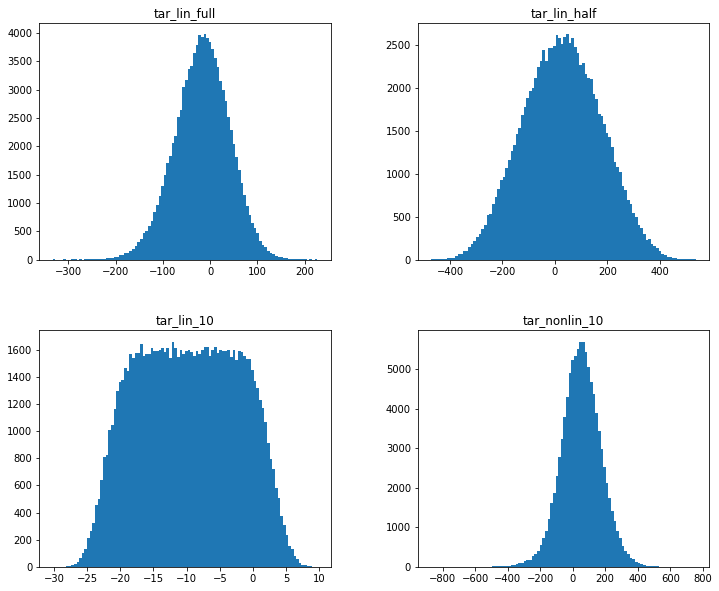

In [10]:
data[[col for col in data.columns if 'tar_' in col]].hist(bins=100, figsize=(12,10), grid=False)
plt.show()

In [11]:
data.to_csv('data/simulated/clean.csv', index=False)

In [12]:
coefs_total = z = {**coefs_linear, **coefs_nonlinear}

with open('data/simulated/coefficients.pkl', 'wb') as f:
    pickle.dump(coefs_total, f)

# Making dirty data

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 104 entries, unc_normal_1 to tar_nonlin_10
dtypes: float64(84), int64(18), object(2)
memory usage: 79.3+ MB


In [14]:
def dirtify(data):
    df = data.copy()
    n_entries = df.shape[0]
    np.random.seed(11)
    
    # adding random noise to some columns
    df['unc_normal_1'] += np.random.normal(loc=0, scale=15, size=n_entries) / 10
    df['corr_normal_by_cat'] += np.random.normal(loc=-0.5, scale=5, size=n_entries) / 10
    df['unc_skewed_neg'] += np.random.normal(loc=0, scale=50, size=n_entries) / 10
    
    
    # make outliers
    random_entries = np.random.random(df.shape[0])<0.00001
    df['unc_normal_2'] = df['unc_normal_2'].mask(random_entries).fillna(df['unc_normal_2'] + 20)
    random_entries = np.random.random(df.shape[0])<0.00001
    df['corr_multinormal_mid_a'] = df['corr_multinormal_mid_a'].mask(random_entries).fillna(df['corr_multinormal_mid_a'] - 54)
    
    return df

In [15]:
data_dirty = dirtify(data)

data_dirty.head()

,unc_normal_1,unc_normal_2,unc_normal_3,unc_normal_4,unc_normal_5,unc_normal_6,unc_normal_7,unc_normal_8,unc_normal_9,unc_normal_10,unc_normal_11,unc_normal_12,unc_normal_13,unc_normal_14,unc_normal_15,unc_normal_16,unc_normal_17,unc_normal_18,unc_normal_19,unc_normal_20,unc_skewed_pos,unc_skewed_neg,unc_binary_1,unc_binary_2,unc_binary_3,unc_binary_4,unc_binary_5,unc_categories_5,unc_categories_3,unc_ordinal_1,unc_ordinal_2,unc_ordinal_3,unc_ordinal_4,unc_ordinal_5,unc_ordinal_6,unc_ordinal_7,unc_ordinal_8,unc_ordinal_9,unc_ordinal_10,unc_ordinal_11,corr_cat_1,corr_cat_2,corr_normal_by_cat,corr_normal_by_2cats,corr_multinormal_high_a,corr_multinormal_high_b,corr_multinormal_mid_a,corr_multinormal_mid_b,corr_multinormal_low_a,corr_multinormal_low_b,conf_normal_1,conf_normal_2,conf_normal_3,conf_normal_4,conf_normal_5,conf_normal_6,conf_normal_7,conf_normal_8,conf_normal_9,conf_normal_10,conf_normal_11,conf_normal_12,conf_normal_13,conf_normal_14,conf_normal_15,conf_normal_16,conf_normal_17,conf_normal_18,conf_normal_19,conf_normal_20,conf_normal_21,conf_normal_22,conf_normal_23,conf_normal_24,conf_normal_25,conf_normal_26,conf_normal_27,conf_normal_28,conf_normal_29,conf_normal_30,conf_normal_31,conf_normal_32,conf_normal_33,conf_normal_34,conf_normal_35,conf_normal_36,conf_normal_37,conf_normal_38,conf_normal_39,conf_normal_40,conf_inter_1,conf_inter_2,conf_inter_3,conf_inter_4,conf_inter_5,conf_inter_6,conf_inter_7,conf_inter_8,conf_inter_9,conf_inter_10,tar_lin_full,tar_lin_half,tar_lin_10,tar_nonlin_10
0,5.740341,1.721656,3.960629,-2.434819,1.571768,-0.463757,0.471428,0.053728,-0.068983,3.661687,0.711273,-0.140425,1.906761,1.173943,0.346412,-0.697281,1.597933,1.656605,-0.653604,-0.055235,4.012600,34.101309,1,0,1,1,1,a,c,9,8,10,27,16,2,22,32,64,99,91,1,0,0.765000,0.351782,8.430675,-3.355695,27.159674,10.704274,-5.322705,7.330677,-0.465424,0.428379,-8.305065,5.433540,0.641474,-0.744669,0.193713,-10.796703,-1.740955,2.789925,4.793788,0.314059,8.809190,-1.724027,-4.859676,-6.392787,0.333997,1.478847,-8.566738,-1.559217,-1.516266,3.860680,2.366172,-2.586560,0.054521,-0.277927,-0.564051,1.594984,-3.057506,2.359598,-3.066961,-2.031134,1.090621,2.271005,-1.542664,0.977127,-1.722407,-0.183448,4.172730,0.060391,2.438407,-0.513521,7.685403,-2.747760,0.665247,33.859922,0.814738,0.118919,78.506972,2.721404,-141.716395,107.030563,-12.790992,253.341695
1,1.045640,2.279144,1.363985,0.924290,0.785104,0.950153,0.751243,-0.286628,2.601363,-0.511723,0.649503,-3.462760,1.950268,0.345893,0.373006,-0.398640,1.412010,2.145148,-1.561932,-1.695599,4.173161,37.740451,1,0,1,1,1,a,a,6,7,8,24,21,19,22,64,12,61,70,1,1,0.705283,-0.629935,3.334968,-0.792505,21.696217,11.128385,-6.570617,2.406493,7.850316,5.888023,1.994081,2.331105,0.695217,-1.471434,-4.009850,-8.008990,-1.708479,2.588924,-2.228353,-0.639126,6.769919,-1.032789,2.209520,5.093657,2.435870,-1.191747,3.121220,-1.031572,-0.675103,3.210031,-4.901169,-5.315658,0.715473,-0.098325,-0.353838,1.130485,-0.718112,6.030474,8.606190,-0.125231,1.515643,1.940682,-5.148735,-1.487067,-4.402883,-0.125751,-0.546949,-1.680762,1.450886,-7.877238,2.677800,0.098183,0.530051,13.925376,0.925748,0.230320,26.636887,9.280622,-26.114426,-37.325061,-11.562013,7.533165
2,0.841784,1.358034,-3.530865,3.196470,1.129391,-1.949721,0.858699,0.083105,0.629930,-0.547036,1.302333,3.936047,-1.068482,5.503111,1.889195,0.764182,1.536993,2.127062,1.393332,0.490684,5.272406,24.686235,1,1,1,1,1,a,c,3,2,12,34,20,46,47,50,57,23,88,1,0,0.923866,2.232988,3.895617,-1.586941,22.708020,10.537641,-4.403688,5.108706,1.437204,-1.072698,1.242264,1.820332,-1.615139,-1.493837,1.253864,-2.667333,-0.460375,3.135342,-4.086399,0.473480,-0.950727,1.942101,0.252077,-0.421147,1.477374,0.137126,-7.004676,0.047859,-2.404984,-1.760097,-5.281338,3.673253,0.158068,-3.225765,0.026224,1.305401,-0.111996,-1.489480,-4.099650,3.310754,0.779214,2.491095,-1.099701,-3.111302,-0.772790,0.088491,3.639642,0.805508,1.749581,5.191982,3.938938,17.852357,2.372882,20.491816,2.

In [16]:
data_dirty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 104 entries, unc_normal_1 to tar_nonlin_10
dtypes: float64(84), int64(18), object(2)
memory usage: 79.3+ MB


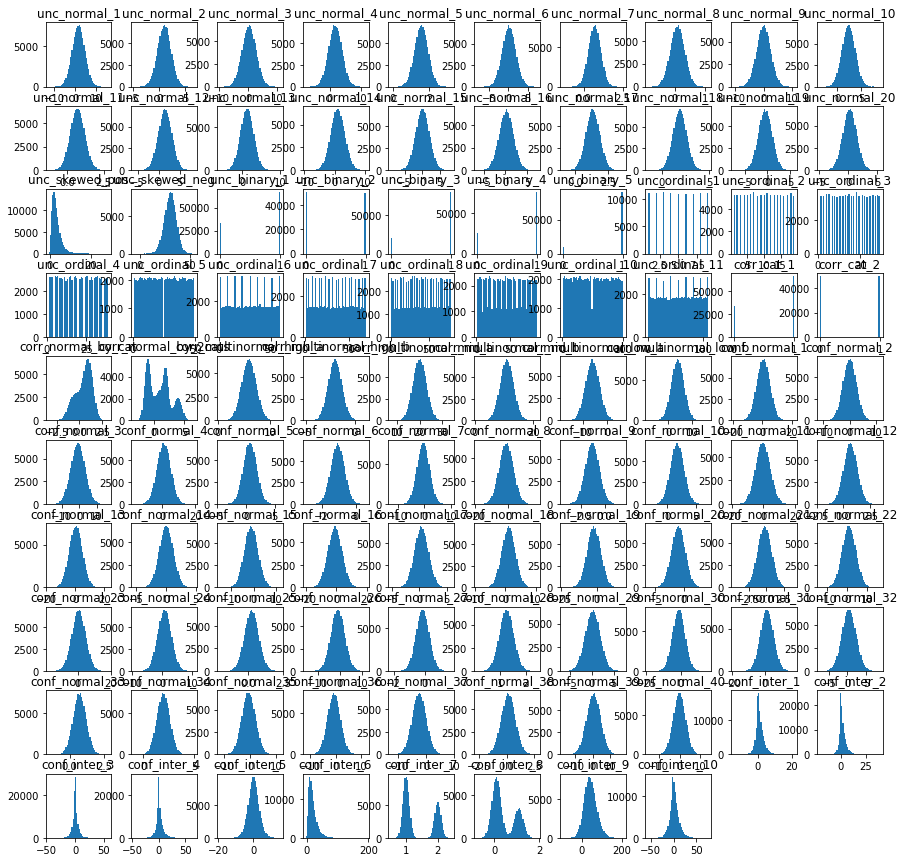

In [17]:
data_dirty[[col for col in data_dirty.columns if 'tar_' not in col]].hist(bins=50, figsize=(15,15), grid=False)
plt.show()

In [18]:
data_dirty.to_csv('data/simulated/dirty.csv', index=False)

# Sklearn datasets

Sklearn gives the possibility of generating datasets suitable for regression with target generated by linear functions. For example, this is a dataframe with 4 variables that all generate the target with no noise

   coefficient variable
0    49.556050        a
1    59.150720        b
2    56.559536        c
3    72.210570        d
               a         b         c         d    target
a       1.000000 -0.165457  0.030217  0.124663  0.409325
b      -0.165457  1.000000 -0.091360  0.018547  0.396926
c       0.030217 -0.091360  1.000000  0.063502  0.450172
d       0.124663  0.018547  0.063502  1.000000  0.709363
target  0.409325  0.396926  0.450172  0.709363  1.000000


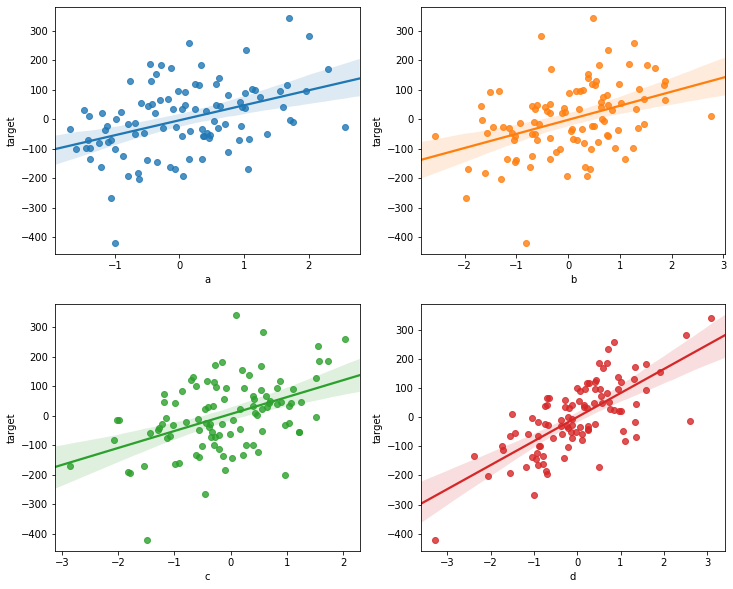

In [19]:
data_sim, target, coefficients = make_regression(n_samples=100, n_features=4, n_informative=4, coef=True, random_state=21, noise=0)

data_sim = pd.DataFrame(data_sim, columns=['a', 'b', 'c', 'd'])
data_sim['target'] = target

coeff = pd.DataFrame(coefficients, columns=['coefficient'])
coeff['variable'] = ['a', 'b', 'c', 'd']

print(coeff)

exp.corr_target(data_sim, 'target', ['a', 'b', 'c', 'd'])

While adding noise would create the following

   coefficient variable
0    49.556050        a
1    72.210570        b
2    56.559536        c
3    59.150720        d
               a         b         c         d    target
a       1.000000  0.124663  0.030217 -0.165457  0.425259
b       0.124663  1.000000  0.063502  0.018547  0.520862
c       0.030217  0.063502  1.000000 -0.091360  0.324699
d      -0.165457  0.018547 -0.091360  1.000000  0.326914
target  0.425259  0.520862  0.324699  0.326914  1.000000


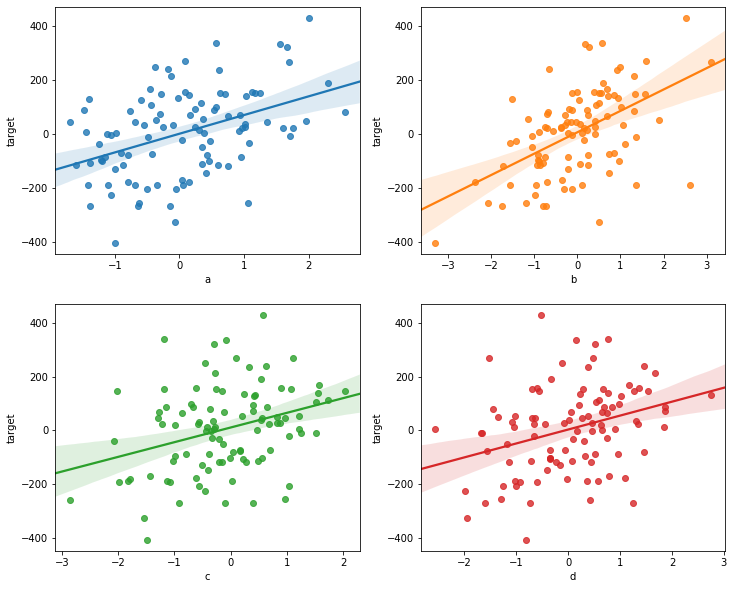

In [20]:
data_sim, target, coefficients = make_regression(n_samples=100, n_features=4, n_informative=4, coef=True, random_state=21, noise=100)

data_sim = pd.DataFrame(data_sim, columns=['a', 'b', 'c', 'd'])
data_sim['target'] = target

coeff = pd.DataFrame(coefficients, columns=['coefficient'])
coeff['variable'] = ['a', 'b', 'c', 'd']

print(coeff)

exp.corr_target(data_sim, 'target', ['a', 'b', 'c', 'd'])

If we want the data to be generated by fewer features, we can achieve it by changing `n_informative`

   coefficient variable
0      0.00000        a
1     49.55605        b
2      0.00000        c
3     72.21057        d
               a         b         c         d    target
a       1.000000  0.030217 -0.091360  0.063502  0.066112
b       0.030217  1.000000 -0.165457  0.124663  0.611663
c      -0.091360 -0.165457  1.000000  0.018547 -0.069970
d       0.063502  0.124663  0.018547  1.000000  0.861198
target  0.066112  0.611663 -0.069970  0.861198  1.000000


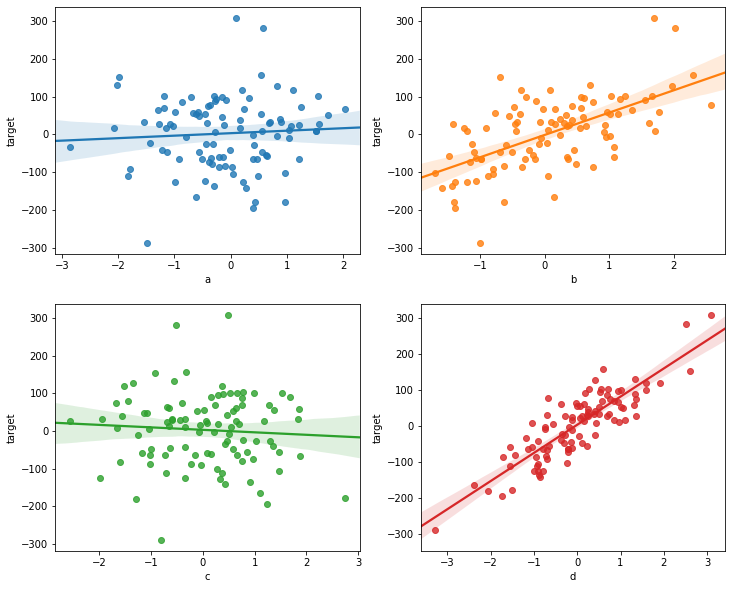

In [21]:
data_sim, target, coefficients = make_regression(n_samples=100, n_features=4, n_informative=2, coef=True, random_state=21, noise=0)

data_sim = pd.DataFrame(data_sim, columns=['a', 'b', 'c', 'd'])
data_sim['target'] = target

coeff = pd.DataFrame(coefficients, columns=['coefficient'])
coeff['variable'] = ['a', 'b', 'c', 'd']

print(coeff)

exp.corr_target(data_sim, 'target', ['a', 'b', 'c', 'd'])

While to simulate a more realistic situation we can play with `effective_rank` 

   coefficient variable
0    79.028462        a
1     5.402325        b
2    55.953174        c
3    50.533446        d
               a         b         c         d    target
a       1.000000  0.037888 -0.311096  0.249183  0.772151
b       0.037888  1.000000  0.221020 -0.239929  0.085003
c      -0.311096  0.221020  1.000000 -0.271181  0.170430
d       0.249183 -0.239929 -0.271181  1.000000  0.542918
target  0.772151  0.085003  0.170430  0.542918  1.000000


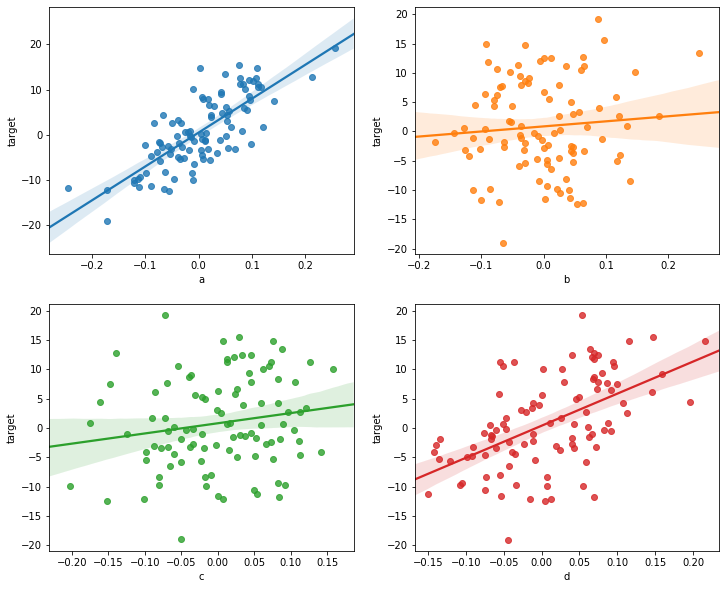

In [22]:
data_sim, target, coefficients = make_regression(n_samples=100, 
                                                 n_features=4, n_informative=4, 
                                                 effective_rank=1, tail_strength=0.8,
                                                 coef=True, random_state=21, noise=0)

data_sim = pd.DataFrame(data_sim, columns=['a', 'b', 'c', 'd'])
data_sim['target'] = target

coeff = pd.DataFrame(coefficients, columns=['coefficient'])
coeff['variable'] = ['a', 'b', 'c', 'd']

print(coeff)

exp.corr_target(data_sim, 'target', ['a', 'b', 'c', 'd'])

We can now create a better function to handle all this.

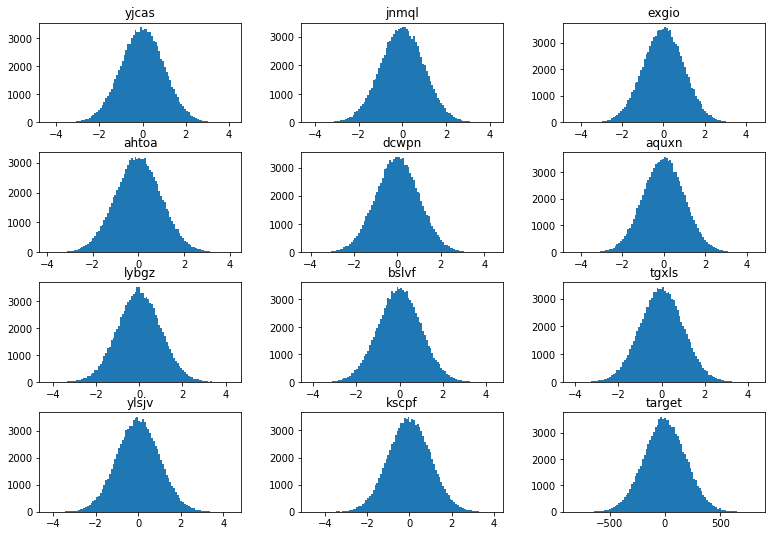

In [23]:
def make_data_regression(n_features, n_informative, noise, effective_rank=None, tail_stregth=0.5):
    data_sim, target, coefficients = make_regression(n_samples=100000, 
                                                 n_features=n_features, n_informative=n_informative, 
                                                 effective_rank=effective_rank, tail_strength=tail_stregth,
                                                 coef=True, random_state=21, noise=noise)
    
    random.seed(23)
    i = 0
    random_names = []
    # generate n_features random strings of 5 characters
    while i < n_features:
        random_names.append(''.join([random.choice(string.ascii_lowercase) for _ in range(5)]))
        i += 1
    
    data_sim = pd.DataFrame(data_sim, columns=random_names)
    data_sim['target'] = target

    coeff = pd.DataFrame({'variable': random_names, 'coefficient': coefficients})
    
    return data_sim, coeff

data_sim, coeff = make_data_regression(11, 11, 0)

data_sim.hist(bins=100, figsize=(13, 9), grid=False)
plt.show()

   variable  coefficient
0     yjcas    60.997032
1     jnmql     4.032212
2     exgio    41.031434
3     ahtoa    35.202247
4     dcwpn    73.137752
5     aquxn    50.407255
6     lybgz     3.263851
7     bslvf    87.278816
8     tgxls    58.465952
9     ylsjv    99.033243
10    kscpf    20.940859
           yjcas     jnmql     exgio     ahtoa     dcwpn     aquxn     lybgz  \
yjcas   1.000000 -0.008356 -0.001930  0.008785 -0.001568 -0.000295 -0.005339   
jnmql  -0.008356  1.000000 -0.003116  0.000220  0.001999  0.005270 -0.001451   
exgio  -0.001930 -0.003116  1.000000 -0.002098 -0.006541 -0.000739  0.004448   
ahtoa   0.008785  0.000220 -0.002098  1.000000 -0.004450 -0.000602 -0.000868   
dcwpn  -0.001568  0.001999 -0.006541 -0.004450  1.000000  0.002326  0.001398   
aquxn  -0.000295  0.005270 -0.000739 -0.000602  0.002326  1.000000 -0.000894   
lybgz  -0.005339 -0.001451  0.004448 -0.000868  0.001398 -0.000894  1.000000   
bslvf   0.001209  0.003597 -0.002456  0.000650 -0.000137 -0.

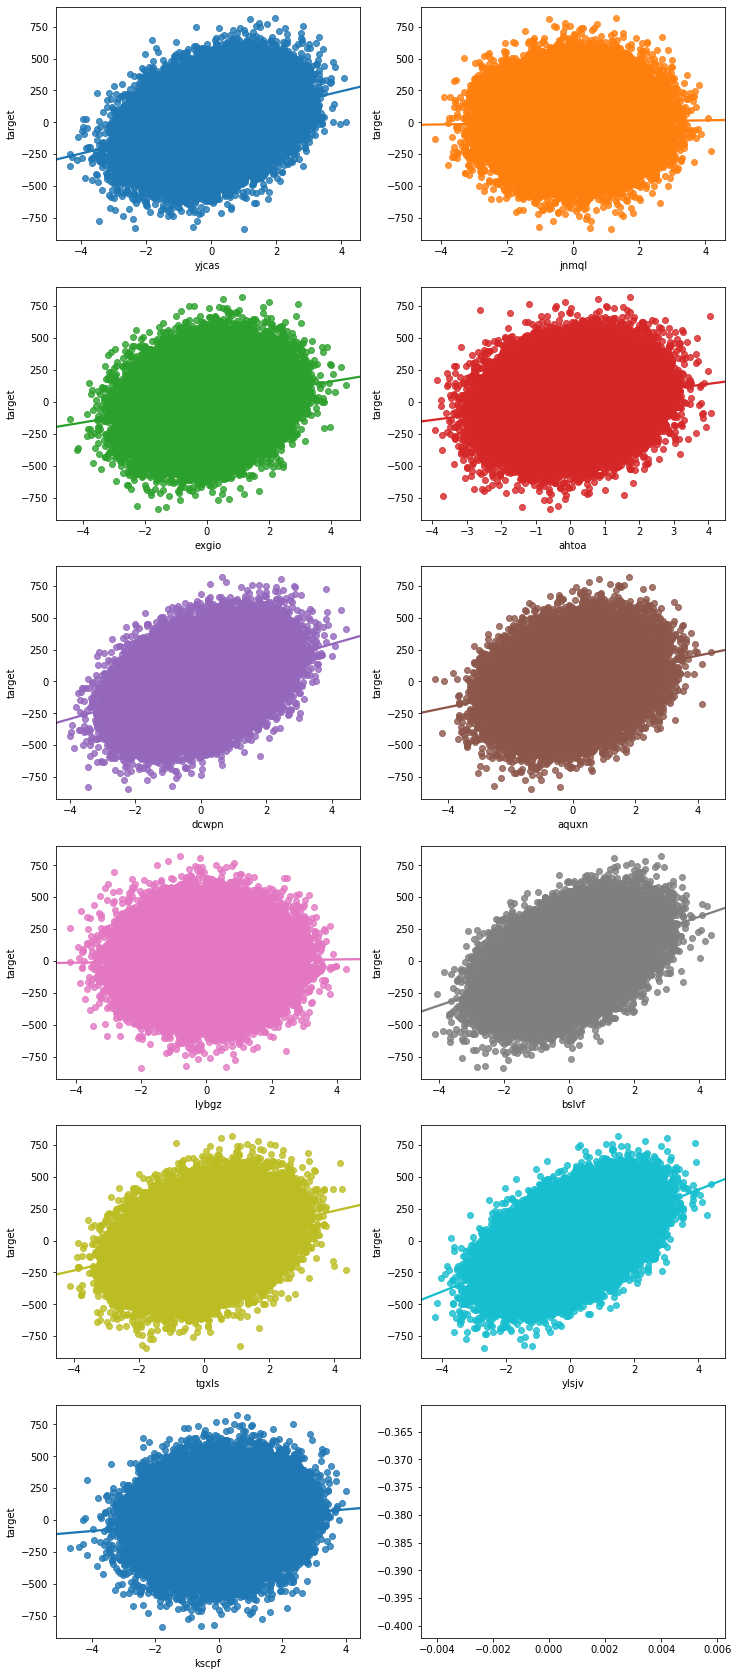

In [24]:
print(coeff)

exp.corr_target(data_sim, 'target', [col for col in data_sim.columns if 'target' not in col])

It is time to generate a bunch of these for our experiments

In [25]:
# 10 features, all used, no noise
data_sim, coeff = make_data_regression(10, 10, 0)
data_sim.to_csv('data/simulated/10_feat_10_inf_nonoise.csv', index=False)
coeff.to_csv('data/simulated/10_feat_10_inf_nonoise__coefficients.csv', index=False)

In [26]:
# 10 features, all used, with noise
data_sim, coeff = make_data_regression(10, 10, 200)
data_sim.to_csv('data/simulated/10_feat_10_inf_noise.csv', index=False)
coeff.to_csv('data/simulated/10_feat_10_inf_noise__coefficients.csv', index=False)

In [27]:
# 100 features, 65 used, No noise
data_sim, coeff = make_data_regression(100, 65, 0)
data_sim.to_csv('data/simulated/100_feat_65_inf_nonoise.csv', index=False)
coeff.to_csv('data/simulated/100_feat_65_inf_noise__coefficients.csv', index=False)

In [28]:
# 100 features, 65 used, with noise
data_sim, coeff = make_data_regression(100, 65, 450)
data_sim.to_csv('data/simulated/100_feat_65_inf_noise.csv', index=False)
coeff.to_csv('data/simulated/100_feat_65_inf_nonoise__coefficients.csv', index=False)

In [29]:
# 100 features, 5 used, with noise
data_sim, coeff = make_data_regression(100, 5, 150)
data_sim.to_csv('data/simulated/100_feat_5_inf_noise.csv', index=False)
coeff.to_csv('data/simulated/100_feat_5_inf_noise__coefficients.csv', index=False)

In [30]:
# 100 features, 100 used, with noise, rank
data_sim, coeff = make_data_regression(100, 100, 1, effective_rank=25, tail_stregth=0.8)
data_sim.to_csv('data/simulated/100_feat_100_inf_noise_rank.csv', index=False)
coeff.to_csv('data/simulated/100_feat_100_inf_noise_rank__coefficients.csv', index=False)

In [31]:
# 100 features, 65 used, with noise, rank
data_sim, coeff = make_data_regression(100, 65, 0.8, effective_rank=20, tail_stregth=0.8)
data_sim.to_csv('data/simulated/100_feat_65_inf_noise_rank.csv', index=False)
coeff.to_csv('data/simulated/100_feat_65_inf_noise_rank__coefficients.csv', index=False)

In [32]:
# 100 features, 50 used, very noise, rank
data_sim, coeff = make_data_regression(100, 50, 10, effective_rank=40, tail_stregth=0.8)
data_sim.to_csv('data/simulated/100_feat_50_inf_verynoise_rank.csv', index=False)
coeff.to_csv('data/simulated/100_feat_50_inf_verynoise_rank__coefficients.csv', index=False)

# Exploration

Just focusing on the simplest targets for brevity

## Linear relations

In [33]:
coefs_linear['tar_lin_10'].sort_values('coef')

,feat,coef
9,unc_ordinal_4,-0.643265
8,unc_normal_5,-0.610497
7,unc_normal_20,-0.429634
2,unc_normal_7,-0.322422
1,unc_normal_6,-0.222742
4,unc_ordinal_10,0.041724
3,unc_normal_9,0.226629
0,unc_binary_1,0.424942
6,unc_normal_4,0.433417
5,unc_normal_10,0.538638


tar_lin_10                 1.000000
unc_ordinal_4             -0.957867
unc_ordinal_10             0.159588
tar_lin_half               0.140663
unc_normal_4               0.115982
unc_normal_10              0.100511
unc_normal_9               0.074693
unc_normal_20             -0.065268
unc_normal_6              -0.050373
unc_normal_5              -0.034886
conf_inter_4               0.032342
unc_binary_1               0.025439
tar_lin_full              -0.019260
unc_normal_7              -0.013177
conf_inter_8               0.012232
unc_ordinal_1              0.011391
conf_normal_16            -0.009588
unc_normal_18              0.007000
corr_multinormal_low_a     0.006667
unc_normal_14             -0.006517
unc_normal_17              0.006480
corr_multinormal_mid_b     0.005790
conf_normal_36             0.005723
unc_normal_16              0.005635
unc_ordinal_5             -0.004775
conf_normal_14             0.004743
conf_normal_7              0.004718
conf_normal_30             0

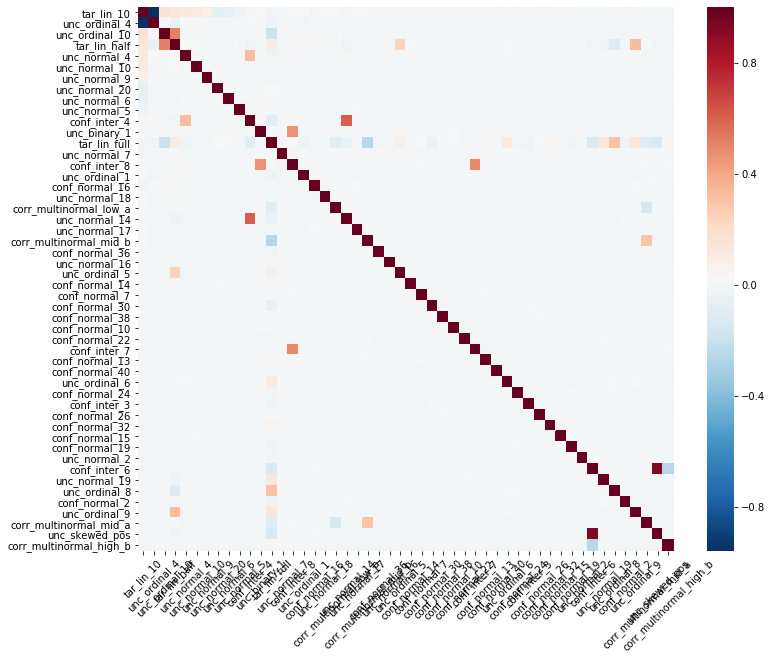

In [34]:
exp.plot_correlations(data, target='tar_lin_10')

                unc_binary_1  unc_normal_6  unc_normal_7  unc_normal_9  \
unc_binary_1        1.000000      0.001269      0.000089      0.003118   
unc_normal_6        0.001269      1.000000      0.001449     -0.005737   
unc_normal_7        0.000089      0.001449      1.000000      0.002332   
unc_normal_9        0.003118     -0.005737      0.002332      1.000000   
unc_ordinal_10     -0.003146     -0.002969      0.001050      0.001632   
unc_normal_10       0.003405     -0.001400     -0.000821      0.000638   
unc_normal_4       -0.004317      0.001001     -0.004601      0.000338   
unc_normal_20       0.005377     -0.001238     -0.001246     -0.001733   
unc_normal_5       -0.001185     -0.001141     -0.002140     -0.004219   
unc_ordinal_4       0.000293     -0.003583     -0.004228      0.001075   
tar_lin_10          0.025439     -0.050373     -0.013177      0.074693   

                unc_ordinal_10  unc_normal_10  unc_normal_4  unc_normal_20  \
unc_binary_1         -0.003146   

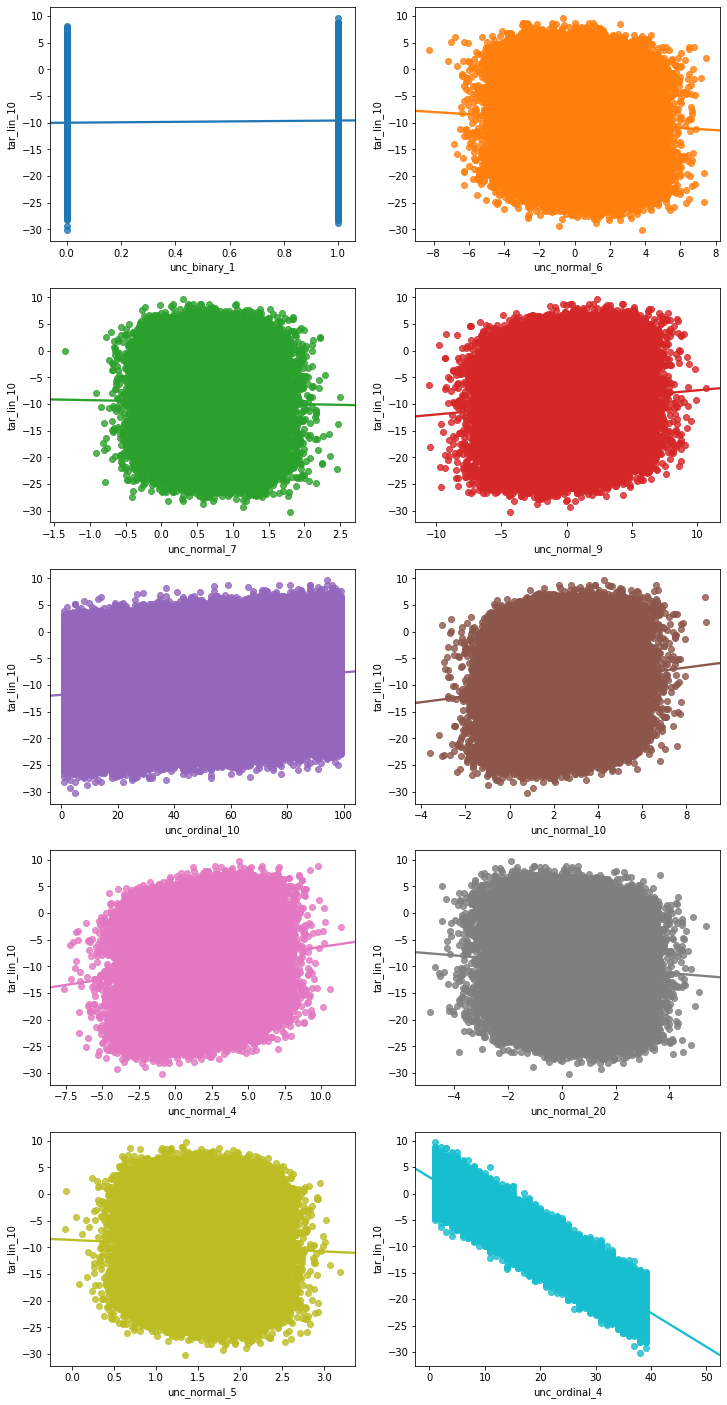

In [35]:
exp.corr_target(data, 'tar_lin_10', list(coefs_linear['tar_lin_10'].feat.values))

## Non-linear relation

In [36]:
coefs_nonlinear['tar_nonlin_10']

,feat,coef
0,unc_normal_1_sq,0.3
1,unc_normal_7_sq,-0.7
2,unc_skewed_int,-1.0
3,corr_multinormal_mid_a_sq,0.8
4,unc_ordinal_5_12,0.5
5,unc_normal_14_by_cat,-0.4
6,unc_normal_1_7,1.0


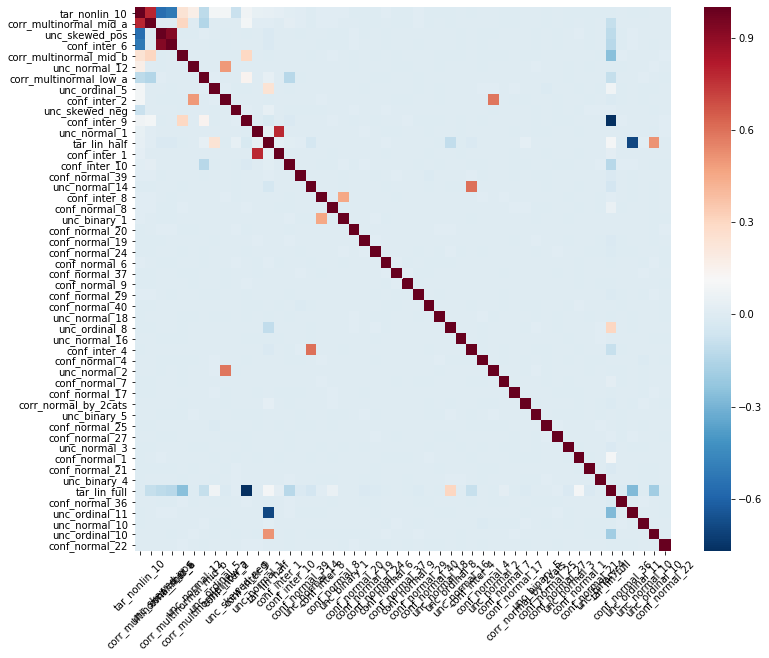

In [37]:
most_corr = exp.plot_correlations(data, target='tar_nonlin_10')

                        corr_multinormal_mid_a  unc_skewed_pos  conf_inter_6  \
corr_multinormal_mid_a                1.000000        0.001816      0.003046   
unc_skewed_pos                        0.001816        1.000000      0.926306   
conf_inter_6                          0.003046        0.926306      1.000000   
corr_multinormal_mid_b                0.303468       -0.002327     -0.001622   
unc_normal_12                         0.002541       -0.002785     -0.001511   
corr_multinormal_low_a               -0.142300        0.006678      0.003992   
tar_nonlin_10                         0.788641       -0.558241     -0.516032   

                        corr_multinormal_mid_b  unc_normal_12  \
corr_multinormal_mid_a                0.303468       0.002541   
unc_skewed_pos                       -0.002327      -0.002785   
conf_inter_6                         -0.001622      -0.001511   
corr_multinormal_mid_b                1.000000       0.000032   
unc_normal_12                     

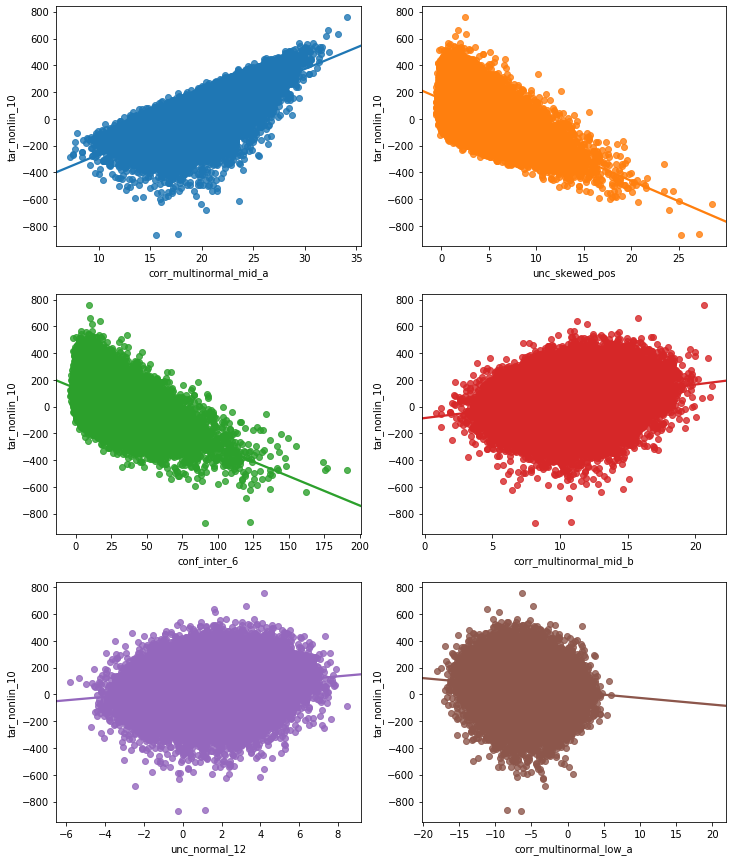

In [38]:
exp.corr_target(data, 'tar_nonlin_10', [col for col in list(most_corr.index[:7]) if 'tar_' not in col])

Interesting to notice how some correlation emerges accidentally between the target and some features not used to generate it